# Versao final - projeto de Redes Sociais

In [1]:
#Import das bibliotecas e criacao do Graph graph dirigido
import pandas as pd
import netpixi #import das bibliotecas necessáriavalue_countss
from netpixi.integration.gt import *
from regression.integration.gt import *
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib

from random import random, seed

graph = Graph(directed=True) #dirigidonão

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


In [2]:
# Datesets contendo as citacoes e as informacoes das patentes
citacoes = pd.read_csv("cite75_99.txt",sep=",")
patent_data = pd.read_csv("apat63_99.txt",sep=",")

In [3]:
# Como iremos trabalhar com somente patentes da categoria de computacao
# Iremos remover todos que pertencem a outras categorias
computacao = patent_data[patent_data["CAT"]==2] #CAT 2 esta na documentacao como sendo de computacao
patentes_computacao = computacao["PATENT"] #pd.series com o numero de todas as patentes de computacao

In [4]:
# Iremos usar a rede inteira para fazer regressao logistica, sem sample
am_pat_comp = patentes_computacao 
am_pat_comp

402        3071203
523        3071324
579        3071380
580        3071381
839        3071641
            ...   
2923917    6009550
2923918    6009551
2923919    6009552
2923920    6009553
2923921    6009554
Name: PATENT, Length: 290337, dtype: int64

In [5]:
# Nesta celula, estamos retirando as patentes gerais que nao pertencem a computacao
cit_comp = citacoes[citacoes["CITING"].isin(am_pat_comp)]
cit_comp = cit_comp[cit_comp["CITED"].isin(am_pat_comp)]

## Preparando o grafo

In [6]:
# Patentes disruptivas eh a variavel independente e patentes importantes eh a variavel dependente
# patentes disruptivas sao medidas pela quantidade de subcategorias de comp que citam ela (qualitativa)
# patentes importantes sao medidas pelo pageRank (quantitativa)
# independente qualitativa e dependente quantitativa
vertex = []
edge = []

# Funcao responsavel por contruir o grafo a partir das informacoes do dataframe cit_comp
def citting(id1,id2):
    id1 = int(id1)
    id2 = int(id2)
    if not graph.has_vertex(id1):
        vertex.append(id1)
        graph.add_vertex(id1)

    if not graph.has_vertex(id2):
        graph.add_vertex(id2)
        vertex.append(id2)
    if not graph.has_edge(id1,id2):
        edge.append([id1,id2])
        edge.append([id1,id2])#ver jeito melhor
        graph.add_edge(id1,id2)
    return id1,id2

a = cit_comp[['CITING', 'CITED']].apply(lambda x: citting(x['CITING'], x['CITED']), axis=1)

In [7]:
# Pegando as metricas locais de degree,pageRank e 
n = graph.num_vertices()
m = graph.num_edges()
if graph.is_directed():
    max_edges = n * (n - 1)
else:
    max_edges = n * (n - 1) // 2
d = m / max_edges

dc = gt_total_degree(graph)
dc_in = gt_in_degree(graph)
dc_out = gt_out_degree(graph)

graph.add_vp('degree',dc)
graph.add_vp('in_degree',dc_in)
graph.add_vp('out_degree',dc_out)

print("Número de vértices = ", n)
print("Número de arestas = ", m)
print("Número máximo de arestas = ", max_edges)
print("Densidade = ",d)

Número de vértices =  273393
Número de arestas =  1552364
Número máximo de arestas =  74743459056
Densidade =  2.0769228767388504e-05


In [8]:
#adicionando coluna de SUBCAT de cada vertice
graph.add_vp('SUBCAT')
for i in graph.all_vertices():

    a = computacao[computacao['PATENT'] == i.get_id()]['SUBCAT']
    teste = a.iloc[0]

    i['SUBCAT'] = str(teste)

In [9]:
# Adicionando cor correspondente a SUBCAT
graph.add_vp('color')
for v in graph.all_vertices(): 
    if v['SUBCAT'] == "21":
        v['color'] = 0xffd700
    elif v['SUBCAT'] == "22":
        v['color'] = 0x00ff00
    elif v['SUBCAT'] == "23":
        v['color'] = 0xE69138
    elif v['SUBCAT'] == "24":
        v['color'] = 0x6AA84F
    else:
        print("outro")

In [10]:
# Adicionando a metrica local pageRank para cada vertice
from graph_tool import centrality
pr = centrality.pagerank(graph)
graph.add_vp('pagerank', pr)
gt_data(graph)

,degree,in_degree,out_degree,SUBCAT,color,pagerank
id,,,,,,
3858799,0.000011,0.000011,0.000011,22,65280,0.000002
3629857,0.000029,0.000059,0.000000,24,6989903,0.000020
3636519,0.000044,0.000088,0.000000,22,65280,0.000028
3748652,0.000007,0.000015,0.000000,24,6989903,0.000005
3858889,0.000009,0.000011,0.000007,24,6989903,0.000003
...,...,...,...,...,...,...
6009550,0.000015,0.000000,0.000029,22,65280,0.000001
6009551,0.000004,0.000000,0.000007,22,65280,0.000001
6009552,0.000009,0.000000,0.000018,22,65280,0.000001


In [11]:
data = gt_data(graph)
info_vertices = data.copy()

In [12]:
info_vertices.reset_index(inplace=True)

In [13]:
info_vertices

,id,degree,in_degree,out_degree,SUBCAT,color,pagerank
0,3858799,0.000011,0.000011,0.000011,22,65280,0.000002
1,3629857,0.000029,0.000059,0.000000,24,6989903,0.000020
2,3636519,0.000044,0.000088,0.000000,22,65280,0.000028
3,3748652,0.000007,0.000015,0.000000,24,6989903,0.000005
4,3858889,0.000009,0.000011,0.000007,24,6989903,0.000003
...,...,...,...,...,...,...,...
273388,6009550,0.000015,0.000000,0.000029,22,65280,0.000001
273389,6009551,0.000004,0.000000,0.000007,22,65280,0.000001
273390,6009552,0.000009,0.000000,0.000018,22,65280,0.000001
273391,6009553,0.000022,0.000000,0.000044,22,65280,0.000001


In [14]:
data_hist = info_vertices.copy()
data_hist['in_degree'] = data_hist['in_degree']*(n-1)
data_hist['out_degree'] = data_hist['out_degree']*(n-1)
data_hist['degree'] = data_hist['degree']*(2*n-2)
data_hist

,id,degree,in_degree,out_degree,SUBCAT,color,pagerank
0,3858799,6.0,3.0,3.0,22,65280,0.000002
1,3629857,16.0,16.0,0.0,24,6989903,0.000020
2,3636519,24.0,24.0,0.0,22,65280,0.000028
3,3748652,4.0,4.0,0.0,24,6989903,0.000005
4,3858889,5.0,3.0,2.0,24,6989903,0.000003
...,...,...,...,...,...,...,...
273388,6009550,8.0,0.0,8.0,22,65280,0.000001
273389,6009551,2.0,0.0,2.0,22,65280,0.000001
273390,6009552,5.0,0.0,5.0,22,65280,0.000001
273391,6009553,12.0,0.0,12.0,22,65280,0.000001


## Histogramas

gt_X_degree e v.X_degree() dao valores diferentes porem corretos

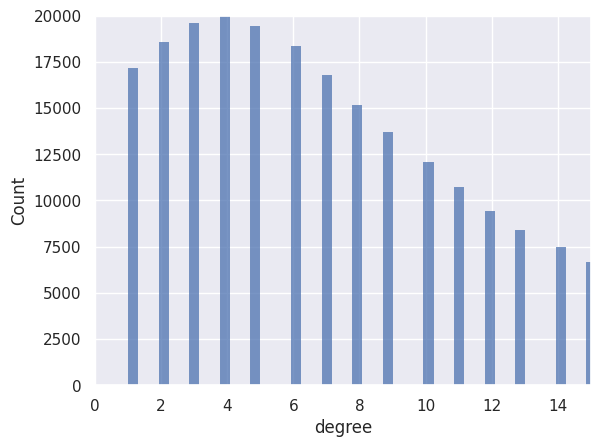

In [15]:
sns.histplot(data_hist['degree'])
data_hist['degree'].describe()
plt.ylim(0,40000)
plt.xlim(0,15)
plt.savefig('describe.png')

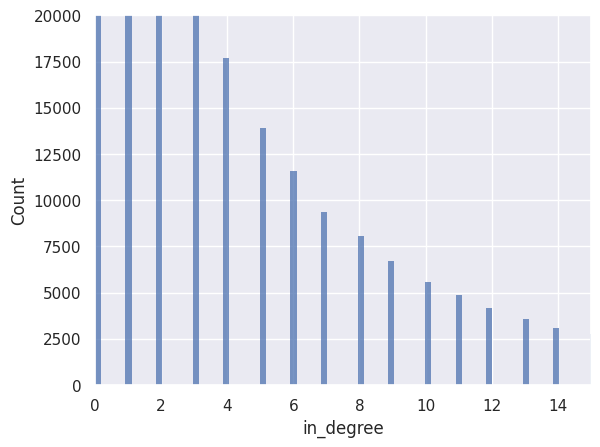

In [16]:
sns.histplot(data_hist['in_degree'])
data_hist['in_degree'].describe()
plt.ylim(0,40000)
plt.xlim(0,15)
plt.savefig('in_describe.png')

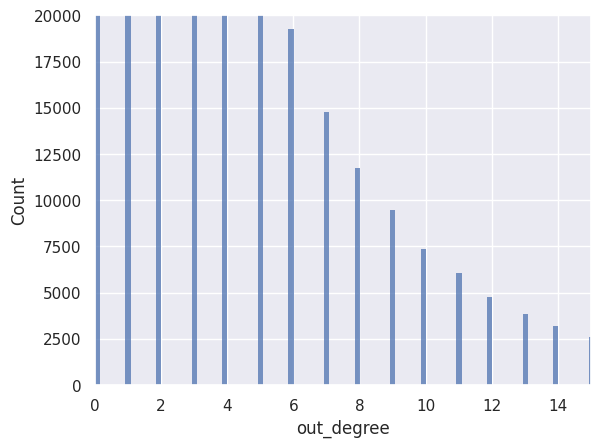

In [17]:
sns.histplot(data_hist['out_degree'])
data_hist['out_degree'].describe()
plt.ylim(0,40000)
plt.xlim(0,15)
plt.savefig('out_describe.png')

### Encontrando quantas subcategorias uma patente da subcategoria x e citada 

Para isso, merge entre info_vertices e cit_comp. Depois groupby cited 

In [18]:
# Merge para pegar subcat de patente CITED e CITTING
cit_comp_info = cit_comp.merge(info_vertices,left_on='CITED',right_on='id',how='left')
cit_comp_info = cit_comp_info.loc[:,['CITING','CITED','SUBCAT','pagerank']]
cit_comp_info = cit_comp_info.rename(columns={'SUBCAT':'SUBCAT_CITED','pagerank':'pagerank_CITED'})

In [19]:
cit_final = cit_comp_info.merge(info_vertices,left_on='CITING',right_on='id',how='left')
cit_final = cit_final.loc[:,['CITING','CITED','SUBCAT_CITED','pagerank_CITED','SUBCAT','pagerank']]
cit_final = cit_final.rename(columns={'SUBCAT':'SUBCAT_CITING','pagerank':'pagerank_CITING'})

In [20]:
cit_final = cit_final.loc[:,['CITED','SUBCAT_CITED','pagerank_CITED','SUBCAT_CITING']]

In [21]:
cit_final

,CITED,SUBCAT_CITED,pagerank_CITED,SUBCAT_CITING
0,3629857,24,0.000020,22
1,3636519,22,0.000028,22
2,3748652,24,0.000005,22
3,3139284,24,0.000003,24
4,3281154,24,0.000003,24
...,...,...,...,...
1552576,5671255,21,0.000002,22
1552577,4611291,22,0.000003,22
1552578,4617662,22,0.000005,22
1552579,4740972,22,0.000002,22


In [22]:
cit_final_entre_pat_diferentes = cit_final[cit_final['SUBCAT_CITED'] != cit_final['SUBCAT_CITING']]
cit_final_entre_pat_iguais = cit_final[cit_final['SUBCAT_CITED'] == cit_final['SUBCAT_CITING']]

In [23]:
a = cit_final_entre_pat_diferentes.groupby(by=['CITED']).nunique()
b = cit_final_entre_pat_iguais.groupby(by=['CITED']).nunique()

In [24]:
a = a.reset_index() #Patente e por quantas subcategorias diferentes ela 'e citada'
b = b.reset_index() #Patente so esta aqui caso tenha sido citada por uma patente de mesma categoria pelo menos uma vez

Caso patente esteja somente em b,quant_subcat=0.

Caso patente esteja em a e b,quant_subcat=valor em a

Caso patente esteja somente em a,quant_subcat=valor em a

In [25]:
a = a.loc[:,['CITED','SUBCAT_CITING']]
b = b.loc[:,['CITED','SUBCAT_CITING']]
a = a.rename(columns={'SUBCAT_CITING':'quant_subcat_diferentes'})
b = b.rename(columns={'SUBCAT_CITING':'quant_subcat_igual'})

In [26]:
correct = a.merge(b,how='outer') #Todas as patentes
# correct['coluna1'].fillna(0, inplace=True)
#Se diferentes e igual for null => quant_total = 0
#Se diferentes for Nan e igual for 1 => quant_total = 0
#Se diferentes for 1 e igual for Nan => quant_total = 1
#Se diferentes for 1 e igual for 1 => quant_total = 1
#...
correct['quant_subcat_diferentes'].fillna(0,inplace=True)
correct['quant_subcat_igual'].fillna(1,inplace=True)
correct['quant_subcat_total'] = correct['quant_subcat_diferentes'] + correct['quant_subcat_igual'] - 1

In [27]:
correct['quant_subcat_total'].describe()

count    207128.000000
mean          0.447250
std           0.646487
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           3.000000
Name: quant_subcat_total, dtype: float64

In [28]:
# Dataframe correct possui todas as patentes de computacao que foram citadas
# Fazer agora um merge entre correct e info_vertices para pegar o pageRank

final = correct.merge(info_vertices,left_on="CITED",right_on="id")
final

,CITED,quant_subcat_diferentes,quant_subcat_igual,quant_subcat_total,id,degree,in_degree,out_degree,SUBCAT,color,pagerank
0,3071649,1.0,1.0,1.0,3071649,0.000005,0.000011,0.000000,22,65280,0.000003
1,3071652,1.0,1.0,1.0,3071652,0.000009,0.000018,0.000000,22,65280,0.000012
2,3071727,1.0,1.0,1.0,3071727,0.000007,0.000015,0.000000,21,16766720,0.000021
3,3071753,2.0,1.0,2.0,3071753,0.000007,0.000015,0.000000,21,16766720,0.000006
4,3072753,1.0,1.0,1.0,3072753,0.000004,0.000007,0.000000,24,6989903,0.000004
...,...,...,...,...,...,...,...,...,...,...,...
207123,5945953,0.0,1.0,0.0,5945953,0.000005,0.000004,0.000007,21,16766720,0.000001
207124,5946156,0.0,1.0,0.0,5946156,0.000091,0.000004,0.000179,24,6989903,0.000002
207125,5949851,0.0,1.0,0.0,5949851,0.000004,0.000004,0.000004,21,16766720,0.000001
207126,5952942,0.0,1.0,0.0,5952942,0.000029,0.000004,0.000055,22,65280,0.000001


In [29]:
# Fazendo o staircase encoding para fazer a regressao logistica
values = list(final['quant_subcat_total'].unique())
values.sort()

def staircase_encoding(vals,df):
    length = len(vals) - 1

    dummies = [[] for i in range(length)]

    for value in df['quant_subcat_total']:
        index = vals.index(value)

        for i in range(index):
            dummies[i].append(1)

        for i in range(index, length):
            dummies[i].append(0)

    for value, dummy in zip(values[1:], dummies):
        df[f'quant_subcat_total{value}'] = dummy
    
    return df

data_reg = staircase_encoding(values,final)

In [30]:
data_reg

,CITED,quant_subcat_diferentes,quant_subcat_igual,quant_subcat_total,id,degree,in_degree,out_degree,SUBCAT,color,pagerank,quant_subcat_total1.0,quant_subcat_total2.0,quant_subcat_total3.0
0,3071649,1.0,1.0,1.0,3071649,0.000005,0.000011,0.000000,22,65280,0.000003,1,0,0
1,3071652,1.0,1.0,1.0,3071652,0.000009,0.000018,0.000000,22,65280,0.000012,1,0,0
2,3071727,1.0,1.0,1.0,3071727,0.000007,0.000015,0.000000,21,16766720,0.000021,1,0,0
3,3071753,2.0,1.0,2.0,3071753,0.000007,0.000015,0.000000,21,16766720,0.000006,1,1,0
4,3072753,1.0,1.0,1.0,3072753,0.000004,0.000007,0.000000,24,6989903,0.000004,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207123,5945953,0.0,1.0,0.0,5945953,0.000005,0.000004,0.000007,21,16766720,0.000001,0,0,0
207124,5946156,0.0,1.0,0.0,5946156,0.000091,0.000004,0.000179,24,6989903,0.000002,0,0,0
207125,5949851,0.0,1.0,0.0,5949851,0.000004,0.000004,0.000004,21,16766720,0.000001,0,0,0
207126,5952942,0.0,1.0,0.0,5952942,0.000029,0.000004,0.000055,22,65280,0.000001,0,0,0


In [31]:
dataa = data_reg.loc[:,['CITED','quant_subcat_total','SUBCAT','pagerank','quant_subcat_total1.0','quant_subcat_total2.0','quant_subcat_total3.0']]

In [32]:
dataa[dataa['quant_subcat_total']==1]

,CITED,quant_subcat_total,SUBCAT,pagerank,quant_subcat_total1.0,quant_subcat_total2.0,quant_subcat_total3.0
0,3071649,1.0,22,0.000003,1,0,0
1,3071652,1.0,22,0.000012,1,0,0
2,3071727,1.0,21,0.000021,1,0,0
4,3072753,1.0,24,0.000004,1,0,0
5,3072857,1.0,21,0.000002,1,0,0
...,...,...,...,...,...,...,...
76428,5930817,1.0,24,0.000001,1,0,0
76429,5943011,1.0,21,0.000001,1,0,0
76430,5943060,1.0,23,0.000002,1,0,0
76431,5944837,1.0,22,0.000001,1,0,0


In [33]:
dataa = dataa.rename(columns={'quant_subcat_total1.0':'quant_subcat_total1','quant_subcat_total2.0':'quant_subcat_total2','quant_subcat_total3.0':'quant_subcat_total3'})

## Regressao Logistica

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import regression as reg

from scipy import stats
from matplotlib import pyplot as plt

In [44]:
result = reg.linear(data=dataa, formula='np.log(pagerank) ~ quant_subcat_total1 + quant_subcat_total2 + quant_subcat_total3')

result.nano_summary()

+0.323 (0.003) ***
+0.499 (0.007) ***
+0.527 (0.019) ***


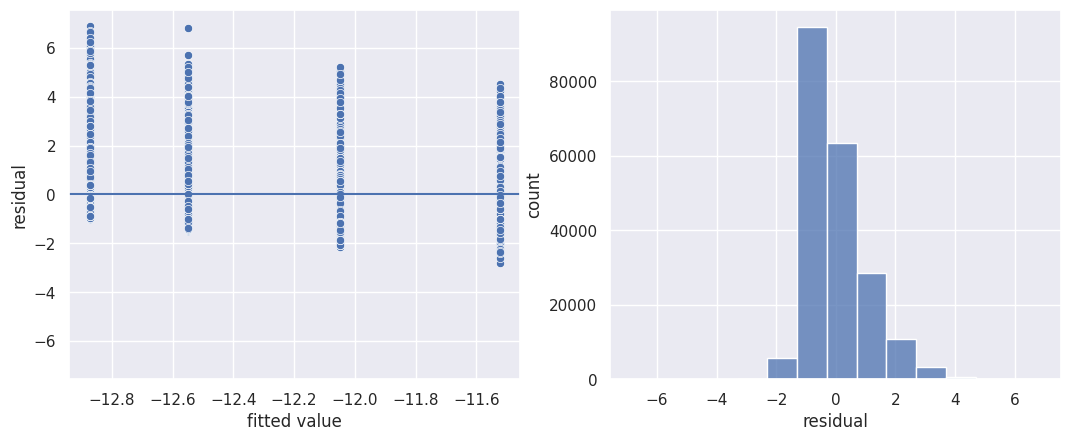

In [37]:
result.plot_residuals()

<AxesSubplot: xlabel='quant_subcat_total', ylabel='pagerank'>

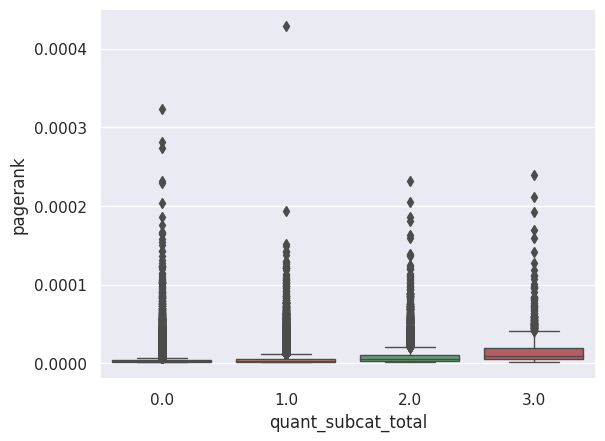

In [38]:
sns.boxplot(x=dataa['quant_subcat_total'], y=dataa['pagerank'], linewidth=1)
# sns.swarmplot(x=dataa['quant_subcat_total1'], y=dataa['pagerank'], linewidth=1)